Planet RapidAI4EO Exploration
===
In this notebook we'll explore the RapidAI4EO dataset created by [Planet](https://www.planet.com/) and hosted by [Radiant Earth Foundation](https://radiant.earth). You can find the landing page for the dataset [here](https://rapidai4eo.radiant.earth) and explore the dataset using the file browser. This dataset consists of around 500,000 chips located across Europe. Each chip contains daily Planet Fusion imagery and monthly Sentinel-2 imagery for the years 2018 and 2019. Each chip also contains [CORINE Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover) labels for each chip. In this notebook we'll explore a single chip, visualizing the true color imagery and then plotting the chip's average NDVI from 2018 to 2019.

Load Label Mappings
===
In this cell we load the CSV which maps label ID numbers to the human-readable label name. For example, a label with an ID of `1` in this CSV maps to the label name `Continuous urban fabric`. We'll reference this mapping later in the notebook.

In [1]:
import csv
label_mappings = {}
with open('rapidai4eo_label_mappings.csv', 'r') as f:
    reader = csv.reader(f)
    header = None
    for row in reader:
        if header is None:
            header = row
            continue
        label_mappings[row[0]] = row[1]

Reading STAC Item
===

In order to keep this notebook brief, we'll load a single pre-defined STAC item which contains the chip's label GeoJSON as well as links to the STAC items for source imagery (Sentinel 2 and Planet Fusion imagery in this case). We will crawl this STAC item and combine all asset links into one dictionary which we will reference in the next cells.

In [2]:
import requests
from urllib.parse import urljoin
from tqdm import tqdm

def getChipFromSTAC(url):
    r = requests.get(url)
    label_item = r.json()
    source_items = {
        
    }
    for link in tqdm(label_item['links']):
        if link['rel'] != 'source':
            continue
            
        source_url = urljoin(url, link['href'])
        r = requests.get(source_url)
        source_item = r.json()
        if source_items.get(source_item['collection']) is None:
            source_items[source_item['collection']] = {}
            
        source_items[source_item['collection']][source_item['id'].split('_')[-1]] = source_item['assets']
        
    return {'assets': label_item['assets'], 'source_assets': source_items}

chip = getChipFromSTAC('https://radiantearth.blob.core.windows.net/mlhub/rapidai4eo/stac-v1.0/rapidai4eo_germany_v1/rapidai4eo_germany_v1_labels/rapidai4eo_germany_v1_labels_32N_13E-229N_02_18/rapidai4eo_germany_v1_labels_32N_13E-229N_02_18.json')

100%|██████████| 162/162 [01:50<00:00,  1.47it/s]


Reading Chip Label
===

In this cell we load the chip's label GeoJSON, sort the [Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover) classes by their percentages, and display the percentage of coverage on the chip for each land cover class and its corresponding human-readable name.

In [3]:
r = requests.get(chip['assets']['labels']['href'])

for k, ratio in sorted(r.json()['properties']['labels'].items(), key=lambda x: x[1], reverse=True):
    label_name = label_mappings.get(k)
    print(f"{ratio * 100:6.2f}% - {label_name}")

 64.17% - Non-irrigated arable land
 35.80% - Broad-leaved forest
  0.03% - Pastures
  0.00% - Continuous urban fabric
  0.00% - Discontinuous urban fabric
  0.00% - Industrial or commercial units
  0.00% - Road and rail networks and associated land
  0.00% - Port areas
  0.00% - Airports
  0.00% - Mineral extraction sites
  0.00% - Dump sites
  0.00% - Construction sites
  0.00% - Green urban areas
  0.00% - Sport and leisure facilities
  0.00% - Permanently irrigated land
  0.00% - Rice fields
  0.00% - Vineyards
  0.00% - Fruit trees and berry plantations
  0.00% - Olive groves
  0.00% - Annual crops associated with permanent crops
  0.00% - Complex cultivation patterns
  0.00% - Land principally occupied by agriculture with significant areas of natural vegetation
  0.00% - Agro-forestry areas
  0.00% - Coniferous forest
  0.00% - Mixed forest
  0.00% - Natural grasslands
  0.00% - Moors and heathland
  0.00% - Sclerophyllous vegetation
  0.00% - Transitional woodland-shrub
  0.00% 

Visualizing a Chip
===

Here we load up the first Planet Fusion and Sentinel 2 chips and visualize them using the rasterio Python package.

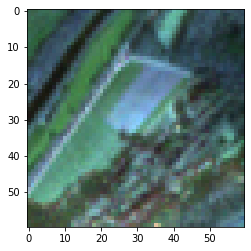

Sentinel 2 - January 2018




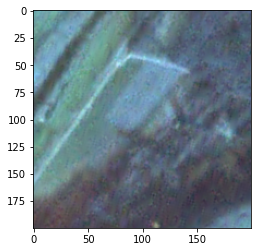

Planet Fusion - January 3rd, 2018


In [5]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot

def visualize(source):
    with rasterio.open(source['sr']['href']) as src:
        data = src.read()[:3].astype('float64')
        data *= 1.0 / data.max()
        show(data)


visualize(chip['source_assets']['rapidai4eo_germany_v1_source_s2']['2018-01'])
print('Sentinel 2 - January 2018\n\n')
visualize(chip['source_assets']['rapidai4eo_germany_v1_source_pf']['2018-01-03'])
print('Planet Fusion - January 3rd, 2018')

Plotting Average NDVI
===

In this next cell, we'll iterate through every Planet Fusion scene captured of the chip and calculate the average [NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) of the scene and plot the resulting values. Here we can see significant seasonal changes in NDVI, just as we would expected for a vegetated area.

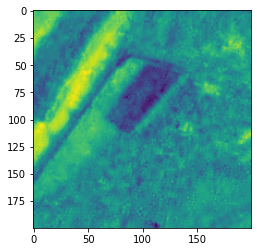

100%|██████████| 146/146 [04:07<00:00,  1.69s/it]

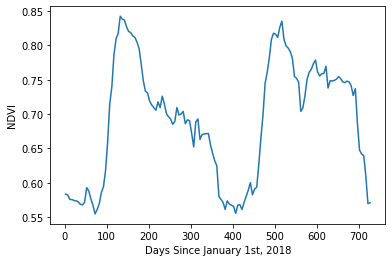

In [6]:
from rasterio.plot import show
from matplotlib import pyplot
import arrow

def ndvi(source, nir, red):
    with rasterio.open(source['sr']['href']) as src:
        data = src.read()
        return (data[nir] - data[red]) / (data[nir] + data[red])


n = ndvi(chip['source_assets']['rapidai4eo_germany_v1_source_pf']['2018-01-03'], nir=3, red=2)
show(n)

start = arrow.get("2018-01-01")
ndvi_values = []

for date in tqdm(list(chip['source_assets']['rapidai4eo_germany_v1_source_pf'].keys())):
    n = ndvi(chip['source_assets']['rapidai4eo_germany_v1_source_pf'][date], nir=3, red=2).mean()
    ndvi_values.append(((arrow.get(date) - start).days, n))
print('\n\n')
pyplot.plot([x[0] for x in ndvi_values], [x[1] for x in ndvi_values])
pyplot.ylabel('NDVI')
pyplot.xlabel('Days Since January 1st, 2018')
pyplot.show()